# Quakes

Copyright William Gacquer 2014, 2015

## Prérequis

Il faut installer les modules Basemap :
>conda install basemap

Malheureusement, sur Windows, Basemap n'est pas disponible officiellement pour les dernières versions de Python et matplotlib. Il faut donc installer une version "custom" disponible sur le site http://www.lfd.uci.edu/~gohlke/pythonlibs/

> pip install basemap-1.0.8-cp34-none-win_amd64.whl

In [1]:
%matplotlib inline
import sys
import numpy as np
import urllib
import urllib.request
import json
import pandas as pd
import hashlib
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import calendar
from mpl_toolkits.basemap import Basemap

In [2]:
svg = False
if (svg==True):
    import mpld3
    from mpld3 import plugins
    mpld3.enable_notebook()
else:
    matplotlib.rcParams['figure.figsize'] = (22.0, 11.0)

## Préparation des données

Il faut dans un premier temps récupérer matière à travailler. Le site de l'USGS sera notre fournisseur.

### Récupération des données

Nous récupérons les données de l'USGS avec la fonction cloneUSGS() qui stocke ces données dans le fichier **earthquakes.csv**. C'est une opération très longue.

In [3]:
def cloneUSGS():
    firstYear = 1973
    thisYear = date.today().year
    thisMonth = date.today().month
    thisDay = date.today().day

    filou = open("earthquakes.csv", "w", encoding="utf-8")

    filou.write("time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type\n")
    for annee in range(firstYear,thisYear+1):
        lastMonth=12
        if annee==thisYear:
            lastMonth = thisMonth
        for mois in range(1,lastMonth+1):
            print("Récupération des données de ",annee,".",mois)
            startday=str(annee)+"-"+str(mois)+"-01"
            endday=str(annee+int(mois/12))+"-"+str((mois%12)+1)+"-01"
            url = "http://comcat.cr.usgs.gov/fdsnws/event/1/query?&minmagnitude=0&format=csv&orderby=time-asc&starttime="+startday+"%2000:00:00&endtime="+endday+"%2000:00:00"
            csvsource = urllib.request.urlopen(url)
            filou.write(csvsource.read().decode('utf-8').replace("time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type\n",""))

Ouverture du fichier contenant les tremblements de terre 
--------------------------------------------------------
Le fichier **earthquakes.pickle** contient l'ensemble des données originales auxquelles ont été ajoutées deux colonnes *HEURE* et *ANNEE*. HEURE est l'heure locale de l'évènement par rapport au soleil.
Si ce fichier n'existe pas, alors on le crée à partir du fichier CSV pour lequel il faut effectuer une petite gymnastique -via la fonction anonyme dateparse- afin de lire correctement la première colonne et de l'interpréter comme une date. 

In [4]:
csv="earthquakes.csv"
pic="earthquakes.pickle"

try:
    data = pd.read_pickle(pic)
except IOError:
    print("Le fichier",pic,"n'existe pas. Chargement du fichier csv") 
    dateParse = lambda x: pd.datetime.strptime(x[0:19],'%Y-%m-%dT%H:%M:%S')
    hourShift = lambda x : (x.time + timedelta(seconds=x.longitude*240)).hour
    yearShift = lambda x : (x.time + timedelta(seconds=x.longitude*240)).year
    try:
        data = pd.read_csv(csv,header=0,parse_dates=[0], date_parser=dateParse)
        data["heure"] = data.apply(hourShift, axis=1)
        data["annee"] = data.apply(yearShift, axis=1)
        data.to_pickle(pic)
    except IOError:
        print("Le fichier",csv,"n'existe pas non plus. Oups!") 


On obtient donc le tableau suivant : 

In [5]:
data

time   latitude   longitude    depth   mag magType  nst  \
0      1973-01-01 03:46:09  -9.214000  150.634000   41.000  5.30      mb  NaN   
1      1973-01-01 05:22:29 -15.012000 -173.958000   33.000  5.00      mb  NaN   
2      1973-01-01 09:28:57 -22.161000  -65.792000  205.000  4.80      mb  NaN   
3      1973-01-01 11:42:37 -35.513000  -16.211000   33.000  6.00      ms  NaN   
4      1973-01-01 21:35:58  13.897000  -44.876000   33.000  4.40      mb  NaN   
5      1973-01-01 21:41:17  13.743000  -45.266000   33.000  4.40      mb  NaN   
6      1973-01-02 00:53:20  -9.854000  117.427000   66.000  5.50      mb  NaN   
7      1973-01-02 01:50:28  38.221000   20.165000   33.000  4.30      mb  NaN   
8      1973-01-02 02:27:09   1.035000  126.211000   61.000  5.40      mb  NaN   
9      1973-01-02 03:03:46  18.923000 -104.127000   33.000  4.60      mb  NaN   
10     1973-01-02 03:47:52   5.404000  -82.541000   30.000  5.20      mb  NaN   
11     1973-01-02 08:16:12  62.570000 -143.678000   33.000  3.70      mb  NaN   
12     1973-01-02 13:03:15   5.535000  127.205000   62.000  4.40      mb  NaN   
13     1973-01-02 13:51:56  71.529000   -5.754000   33.000  4.50      mb  NaN   
14     1973-01-02 16:25:36  36.085000   71.308000  137.000  4.80      mb  NaN   
15     1973-01-02 22:25:57  31.241000   88.088000   33.000  5.20      mb  NaN   
16     1973-01-02 23:20:16  71.330000   -7.551000   33.000  4.70      mb  NaN   
17     1973-01-03 02:29:42   1.548000  126.305000   33.000  4.80      mb  NaN   
18     1973-01-03 02:58:16 -27.716000  -63.261000  563.000  5.60      mb  NaN   
19     1973-01-03 04:10:04  13.466000  120.832000  139.000  4.80      mb  NaN   
20     1973-01-03 06:47:47  16.809000  145.674000  177.000  4.00      mb  NaN   
21     1973-01-03 14:31:04  39.114000   71.889000   33.000  5.50      mb  NaN   
22     1973-01-03 15:05:16  39.119000   72.097000   33.000  4.80      mb  NaN   
23     1973-01-03 20:36:06  39.043000   72.572000   33.000  4.70      mb  NaN   
24     1973-01-03 21:14:16  44.344000 -129.154000   18.000  5.30      mb  NaN   
25     1973-01-03 21:17:28  -3.759000  151.679000   41.000  4.90      mb  NaN   
26     1973-01-04 00:31:42  41.305000  -29.272000   33.000  4.50      mb  NaN   
27     1973-01-04 01:07:50 -13.382000  167.092000  194.000  5.10      mb  NaN   
28     1973-01-04 03:30:38  71.585000   -6.701000   33.000  4.40      mb  NaN   
29     1973-01-04 08:03:50  71.109000   -7.666000   33.000  5.10      mb  NaN   
...                    ...        ...         ...      ...   ...     ...  ...   
866687 2015-05-29 18:48:54  49.087500 -122.377000   10.140  1.03      md    4   
866688 2015-05-29 18:59:43  37.650333 -118.816500    4.360  1.34      md   24   
866689 2015-05-29 19:12:42  45.821500 -123.533667    0.020  0.69      md    2   
866690 2015-05-29 19:21:09  38.843666 -122.801002    2.350  0.68      md   12   
866691 2015-05-29 19:23:25  64.592600 -151.228600    0.100  1.20      ml  NaN   
866692 2015-05-29 19:25:27  36.685501 -121.157333   12.770  1.73      md   18   
866693 2015-05-29 19:37:54  60.365500 -147.770200   12.900  1.30      ml  NaN   
866694 2015-05-29 19:38:56  33.874167 -117.506167    0.010  0.57      ml    7   
866695 2015-05-29 19:48:09  45.066167 -123.109667    0.020  2.30      ml   12   
866696 2015-05-29 19:50:20  60.998200 -148.984200   23.000  1.40      ml  NaN   
866697 2015-05-29 19:57:42  38.819332 -122.765999    2.480  1.75      md   30   
866698 2015-05-29 20:00:15  33.528000 -116.735833    5.220  0.11      ml    7   
866699 2015-05-29 20:04:58  38.821835 -122.846169    2.610  0.55      md    9   
866700 2015-05-29 20:11:42  41.676167 -112.090500   -0.220  1.49      ml   16   
866701 2015-05-29 20:16:21  19.358500 -155.472667    5.180  1.44      md   37   
866702 2015-05-29 20:19:24  38.832165 -122.771332    2.720  0.38      md    8   
866703 2015-05-29 20:22:15  35.860167 -117.686167    4.850  2.28      ml   35   
866704 2015-05-29 20:23:33  35.849000 -117.691667    

Que contient ce tableau? Regardons de plus près. Nous voyons qu'il contient aussi des séismes induits :

In [6]:
data.type.value_counts()

earthquake             861921
quarry                   2137
quarry blast             1080
explosion                 913
mining explosion          357
rock burst                177
nuclear explosion          61
anthropogenic event        43
mine collapse              20
chemical explosion          2
landslide                   2
acoustic noise              2
sonic boom                  1
sonicboom                   1
dtype: int64

## Fonctions de sélection et d'affichage

Sélectionnons uniquement les tremblements de terre, en excluant les séismes induits connus :

In [7]:
magnitude_min = 0.0
magnitude_max = 10.0
date_min = pd.datetime.strptime('1973/01/01 00:00:00','%Y/%m/%d %H:%M:%S')
date_max = pd.datetime.strptime('2015/04/01 00:00:00','%Y/%m/%d %H:%M:%S')
cause = 'earthquake'
quakes = data[ (data.type==cause) & (data.mag>magnitude_min) & (data.mag<magnitude_max) & ( data.time > date_min )& ( data.time < date_max )]

C'est un peu long, non? donc créons la fonction **selection()** qui retourne une sous liste en fonction de différents critères:

In [8]:
def selection(donnees, 
                magnitudeMin = 0.0,
                magnitudeMax = 10.0,
                dateMin = '1973/01/01 00:00:00',
                dateMax = '2100/01/01 00:00:00',
                longitudeMin = -180.0,
                longitudeMax = +180.0,
                latitudeMin = -90.0,
                latitudeMax = +90.0,              
                cause = 'earthquake'
             ):
    date_min = pd.datetime.strptime(dateMin,'%Y/%m/%d %H:%M:%S')
    date_max = pd.datetime.strptime(dateMax,'%Y/%m/%d %H:%M:%S')
    if cause == "all":
        return donnees[  (donnees.latitude>latitudeMin) & (donnees.latitude<latitudeMax) 
                       & (donnees.longitude>longitudeMin)& (donnees.longitude<longitudeMax) 
                       & (donnees.mag>magnitudeMin) & (donnees.mag<magnitudeMax) 
                       & (donnees.time > date_min)& (donnees.time < date_max)
                      ]
    elif cause == "nonSeismic":
        return donnees[  (donnees.type!="earthquake")
                       & (donnees.latitude>latitudeMin) & (donnees.latitude<latitudeMax) 
                       & (donnees.longitude>longitudeMin)& (donnees.longitude<longitudeMax)
                       & (donnees.mag>magnitudeMin) & (donnees.mag<magnitudeMax) 
                       & ( donnees.time > date_min )& ( donnees.time < date_max )
                      ]
    else:
        return donnees[ (donnees.type==cause) 
                       & (donnees.latitude>latitudeMin) & (donnees.latitude<latitudeMax) 
                       & (donnees.longitude>longitudeMin)& (donnees.longitude<longitudeMax)
                       & (donnees.mag>magnitudeMin) & (donnees.mag<magnitudeMax) 
                       & ( donnees.time > date_min )& ( donnees.time < date_max )
                      ]

Implémentons une fonction pour afficher la carte de la sélection:

In [9]:
def afficheLesSeismes(quakes,
                      longitudeMin = -180.0,
                      longitudeMax = +180.0,
                      latitudeMin = -90.0,
                      latitudeMax = +90.0,
                      qualite = 'c' # background image resolution. Can be c (crude), l (low), i (intermediate), h (high), f (full) or None.
                     ):
    #m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90, llcrnrlon=-180,urcrnrlon=180,resolution='c')
    m = Basemap(projection='cyl',llcrnrlat=latitudeMin,urcrnrlat=latitudeMax, llcrnrlon=longitudeMin,urcrnrlon=longitudeMax,resolution=qualite)
    m.etopo()
    m.drawparallels(np.arange(-90.,91.,30.))
    m.drawmeridians(np.arange(-180.,181.,60.))
    m.drawmapboundary(fill_color='aqua')
    m.scatter(quakes.longitude,quakes.latitude,s=quakes.mag,color='red')
    plt.title("Equidistant Cylindrical Projection")
    plt.show()

##Etude de la distribution des évènements

loi de Gutenberg-Richter
-----------------------

Nous rappelons qu'empiriquement, la loi de Gutenberg-Richter donne le nombre de tremblements de terre par magnitude pour une surface donnée et un temps d'observation suffisament long. 

Cette loi s'écrit $N = 10^{a-bM}$ où N est le nombre de tremblements de terre, M est la magnitude, a et b sont des constantes empiriques.
![Ooops, on a perdu l'image!](https://upload.wikimedia.org/wikipedia/en/thumb/a/ae/GR_law_b%3D1.svg/350px-GR_law_b%3D1.svg.png)

Bref, c'est une belle décroissance exponentielle comme on peut en trouver partout dans la nature quand on ne sait pas quand un évenement va se produire.

Etude sur l'ensemble des données de l'USGS
---------------------------------------
Sélectionnons tous les séismes naturels relevés par l'USGS et affichons leur distribution par magnitude.


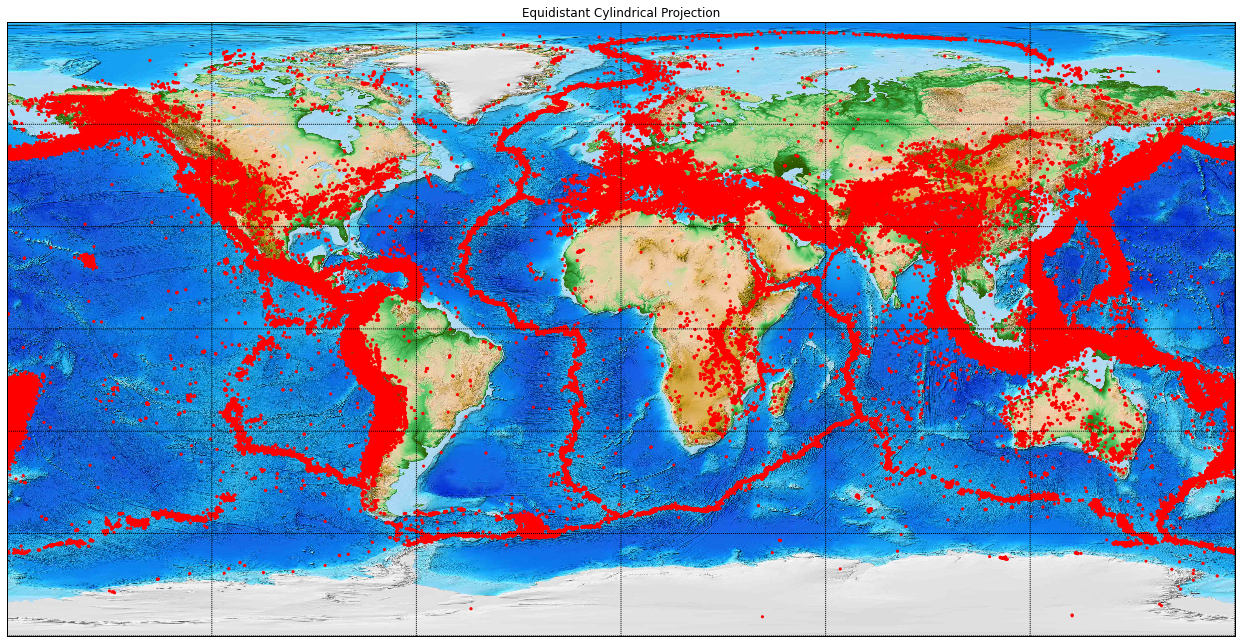

In [10]:
quakes = selection(data, 
                   dateMin = '1973/01/01 00:00:00', 
                   dateMax = '2100/01/01 00:00:00', 
                   cause = "earthquake")
afficheLesSeismes(quakes)

###Histogramme des événements par magnitude

<Container object of 10 artists>

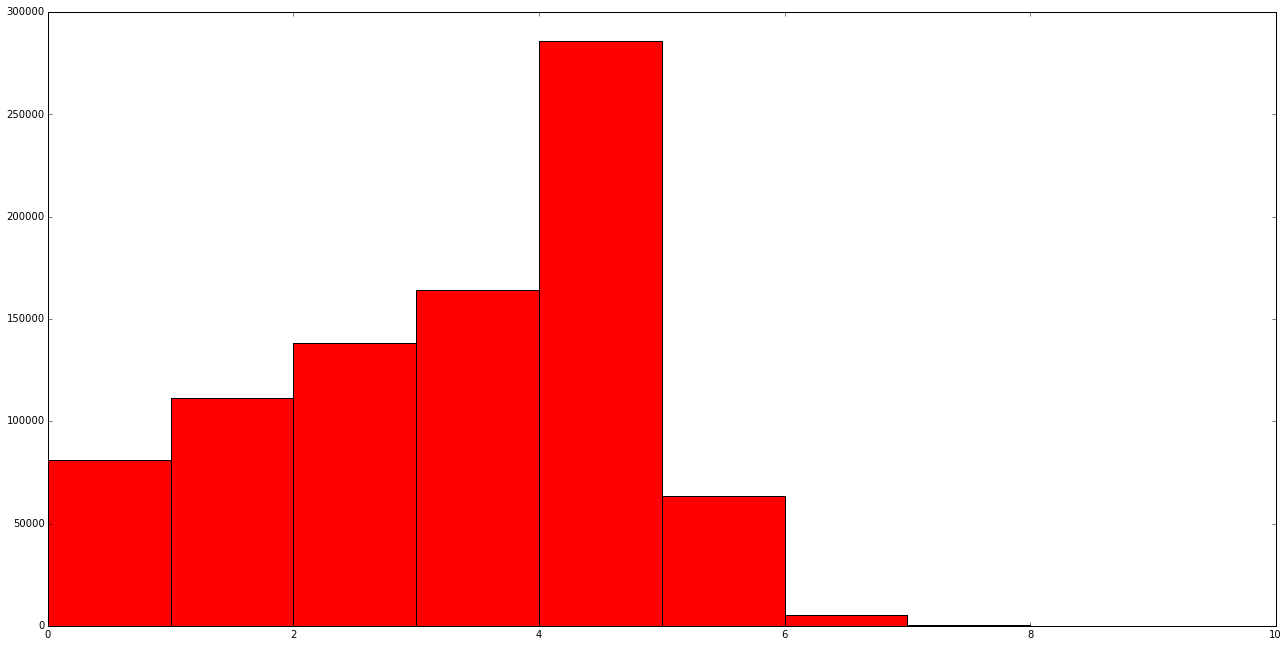

In [11]:
#quakes.mag.hist(range=[0,10])
#quakes.mag.plot(kind="hist", alpha=0.5)
occurences, magnitudes = np.histogram(quakes.mag,10,range=[0,10])
plt.bar(magnitudes[:-1],occurences,width=1, color='red', alpha=1)

Fichtre! Mais où est la ressemblance avec la loi de Gutenberg-Richter dans les données de l'USGS? Il y a bien une décroissance exponentielle, mais pour une magnitude supérieure à 4 uniquement.

Pourquoi est-ce ainsi? 
Il faut chercher la réponse dans la formulation de la loi de Gutenberg-Richter : L'USGS ne couvre pas la totalité de la planète sur tout le spectre des magnitudes. La distribution clairesemée des détecteurs favorise la détection des tremblements de terre de forte magnitude - car ils sont détectables sur une plus grande surface - et la majeure partie des plus faibles tremblements de terre n'est pas détectée, faute de détecteurs locaux.

On peut le constater en affichant la carte des tremblements de terre de magnitude inférieure à 3, par exemple. On voit alors que seules quelques régions - USA, Europe, Caraïbes, Nord de la Nouvelle Zélande -sont bien équippées pour détecter les événements faibles.

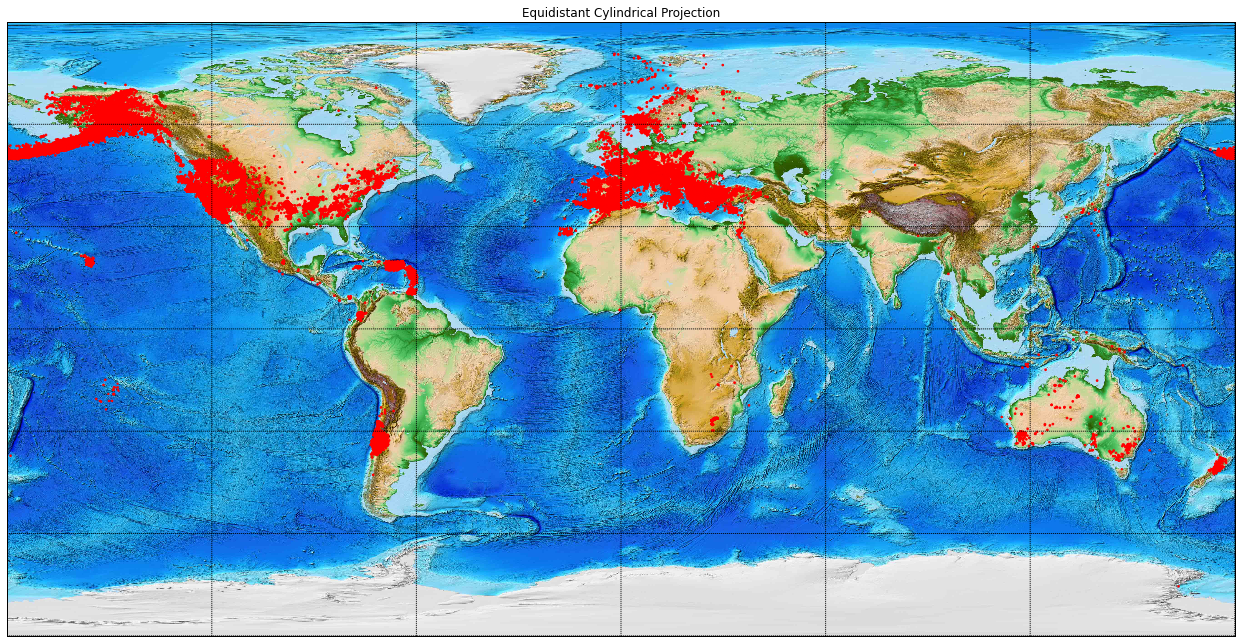

In [12]:
quakes = selection(data, 
                   dateMin = '1973/01/01 00:00:00', 
                   dateMax = '2100/01/01 00:00:00', 
                   cause = "earthquake", 
                   magnitudeMin = 0.0, 
                   magnitudeMax = 3.0)
afficheLesSeismes(quakes)

Il faut donc recommencer l'expérience en ciblant une zone correctement équipée.

## Etude de la sismicité de l'Italie

Effectuons une analyse des données comprises dans un carré tel que :                 
                   latitude minimum = 36.50,
                   latitude maximum = 47.26,
                   longitude minimum = 5.03,
                   longitude maximum = 18.98

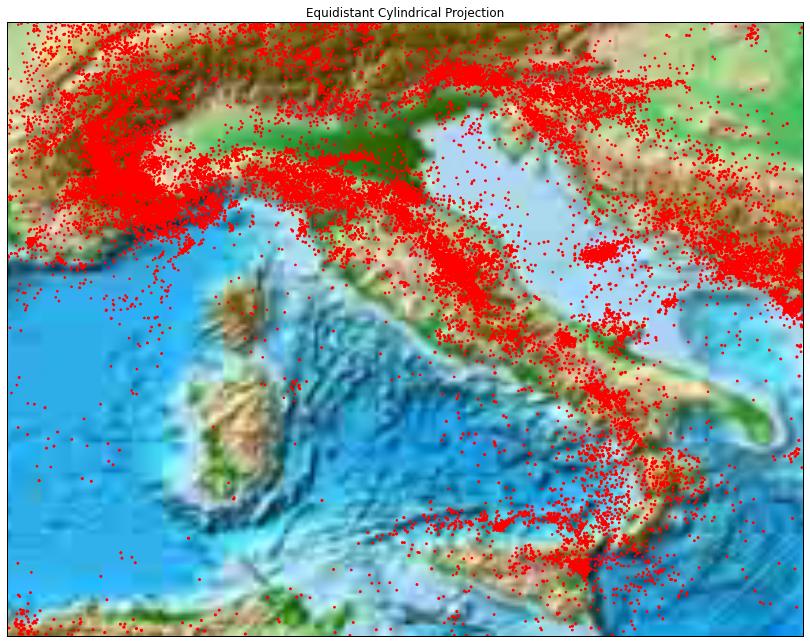

In [13]:
quakes = selection(data, 
                   dateMin = '1973/01/01 00:00:00', 
                   dateMax = '2100/01/01 00:00:00', 
                   cause = "earthquake", 
                   magnitudeMin = 0.0, 
                   magnitudeMax = 10.0,
                   latitudeMin = 36.50,
                   latitudeMax = 47.26,
                   longitudeMin = 5.03,
                   longitudeMax = 18.98
                   )
afficheLesSeismes(quakes, latitudeMin = 36.50, latitudeMax = 47.26, longitudeMin = 5.03, longitudeMax = 18.98, qualite='i')

### Estimation des paramètres a et b de la loi de Gutenberg-Richter pour l'Italie
L'histogramme Occurences/magnitudes se rapproche de la loi de Gutenberg-Richter, avec toujours un défaut pour les plus petites magnitudes inférieures à 2.

<Container object of 50 artists>

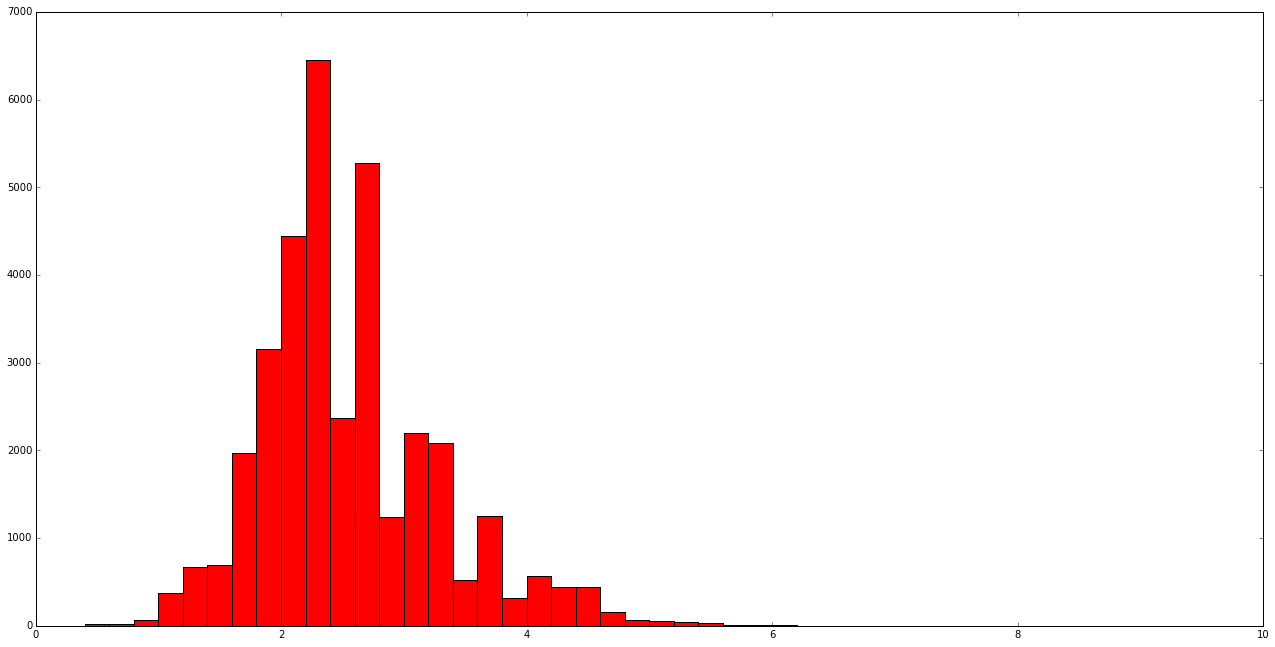

In [14]:
occurences, magnitudes = np.histogram(quakes.mag,50,range=[0,10])
plt.bar(magnitudes[:-1],occurences,width=0.2, color='red', alpha=1)

Déterminons les paramètres a et b de la loi de Gutenberg-Richter appliquée à cette sélection réduite aux magnitudes supérieures à 2.

In [15]:
quakes = selection(data, 
                   dateMin = '1973/01/01 00:00:00', 
                   dateMax = '2100/01/01 00:00:00', 
                   cause = "earthquake", 
                   magnitudeMin = 2.0, 
                   magnitudeMax = 10.0,
                   latitudeMin = 36.50,
                   latitudeMax = 47.26,
                   longitudeMin = 5.03,
                   longitudeMax = 18.98
                   )

from scipy.optimize import curve_fit

def GutenbergRichter(m, a, b):
    return np.power(10,(a-b*m))

occurences, magnitudes = np.histogram(quakes.mag,50,range=[2,10])

(a,b), abcov = curve_fit(GutenbergRichter, magnitudes[:-1], occurences)

Les parametres de la loi Gutenberg-Richter ont donc comme valeurs:

In [16]:
a,b

(4.3722991951148416, 0.39528823797729434)

Comparons les données mesurées -en rose- à la loi ajustée -en bleu-:

<Container object of 50 artists>

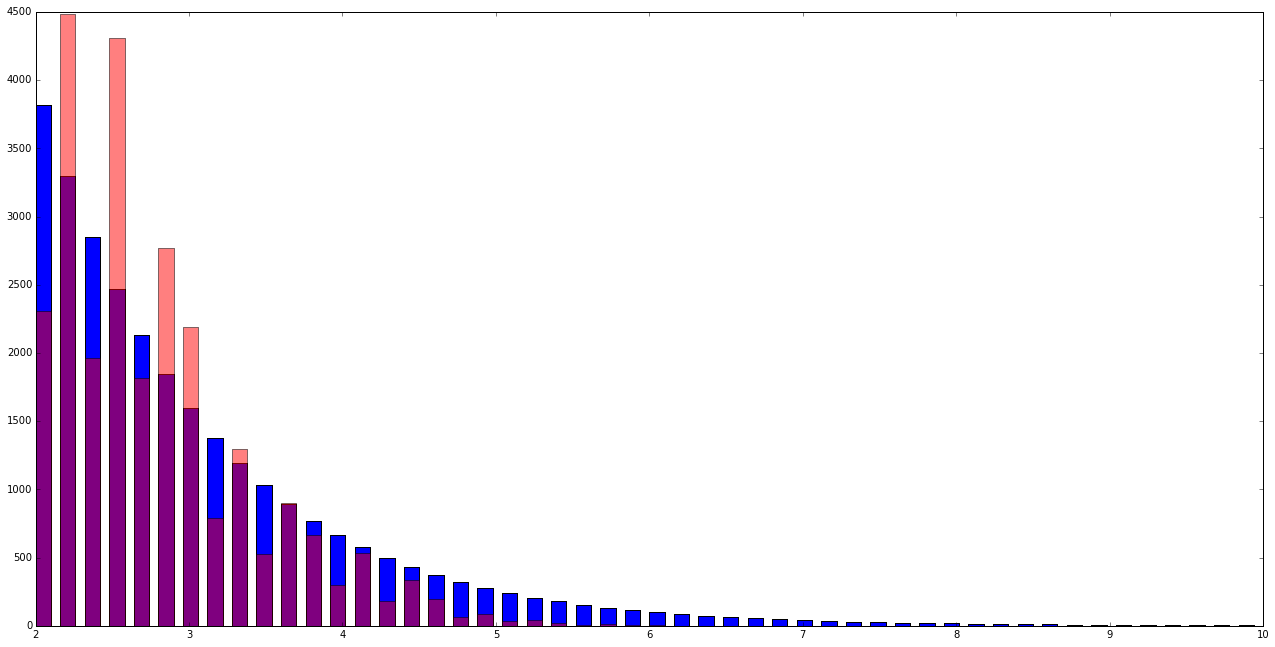

In [17]:
plt.bar(magnitudes[:-1],GutenbergRichter(magnitudes[:-1],a,b),width=0.1, color='blue', alpha=1.0)
plt.bar(magnitudes[:-1],occurences,width=0.1, color='red', alpha=0.5)

## Effet jour/nuit

On cherche a établir une corrélation - ou une absence de corrélation - entre l'alternance jour/nuit et le nombre de tremblements de terre.

###Histogramme des évènements par heure locale

Affichons le nombre de tremblements de terre en fonction de l'heure locale. 

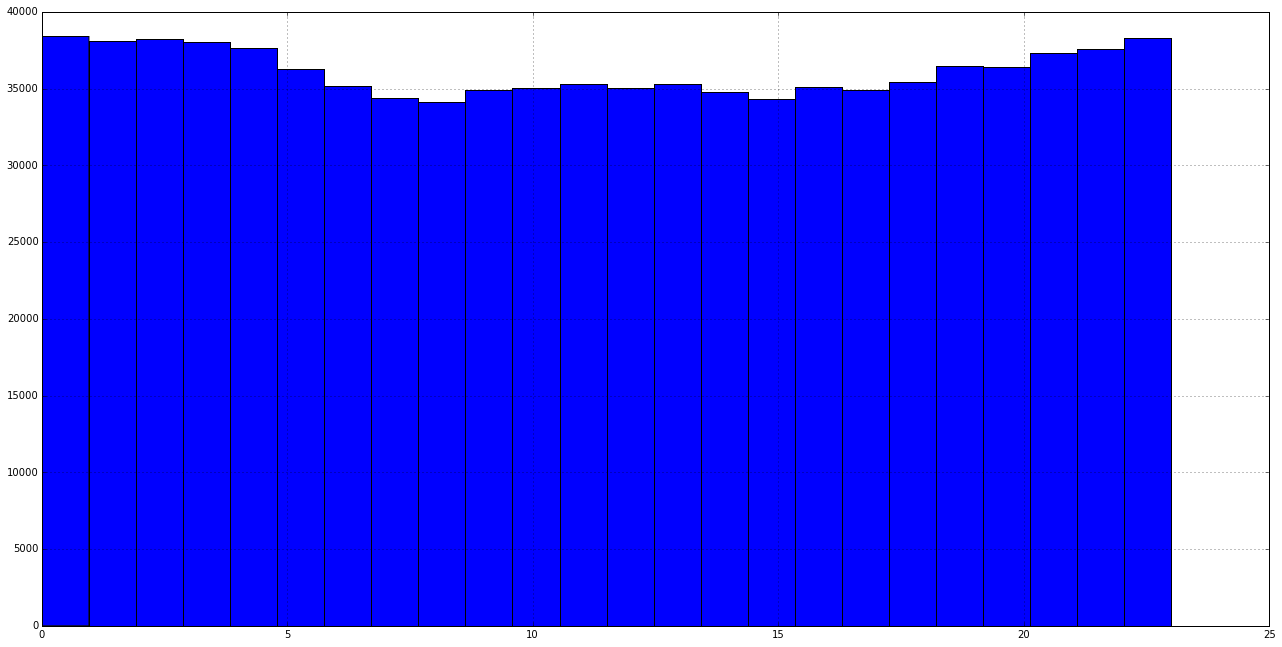

In [18]:
data.heure.hist(bins=24);

On constate une petite variation.
Faisons le même exercice, année par année.

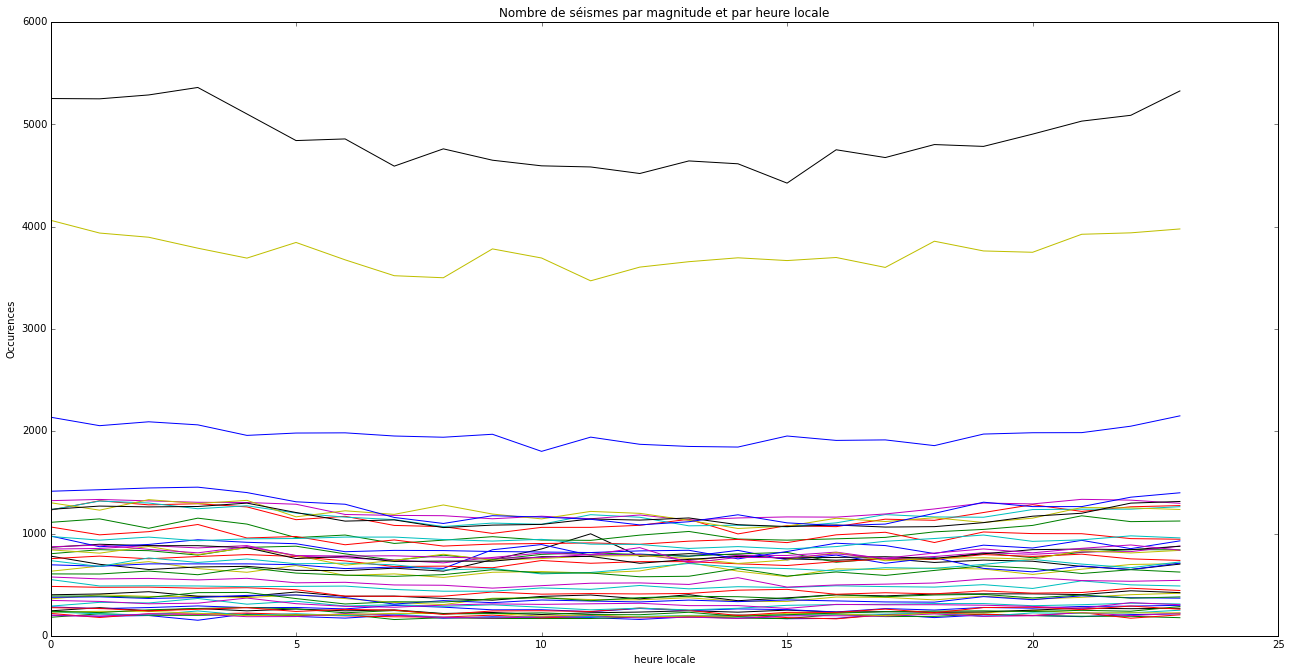

In [19]:
for i in range(1973,2016):
    quakes = selection(data, dateMin = str(i)+'/01/01 00:00:00', dateMax = str(i+1)+'/01/01 00:00:00', cause = "earthquake")
    #afficheLesSeismes(quakes)
    occurences, heures = np.histogram(quakes.heure,24,range=[0,24])
    plt.plot(heures[:-1],occurences)
plt.ylabel('Occurences')
plt.xlabel('heure locale')
plt.title('Nombre de séismes par magnitude et par heure locale')
plt.show()
plt.close()

Bof, ce n'est pas très intéressant. On constate juste que le nombre d'évenements mesurés a augmenté significativement varié entre 1973 et maintenant. Affichons pour information le nombre d'évenement par année :

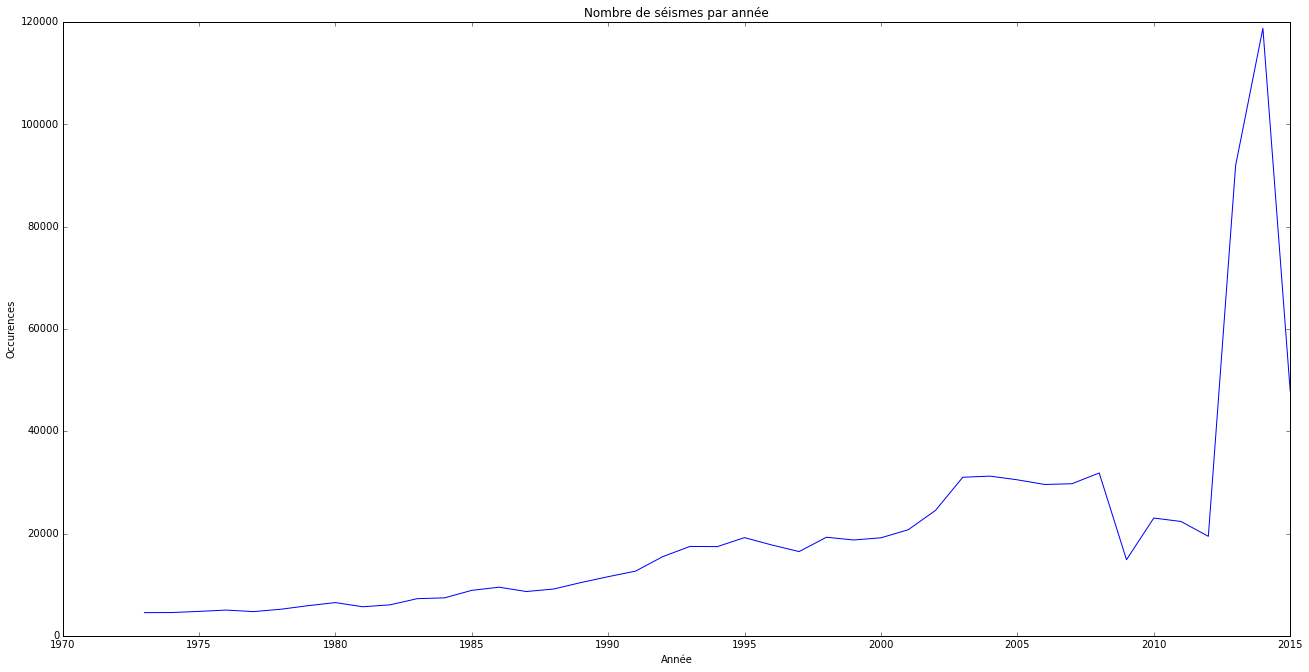

In [20]:
occurences, annees = np.histogram(data.annee,43,range=[1973,2016])
plt.plot(annees[:-1],occurences)
plt.ylabel('Occurences')
plt.xlabel('Année')
plt.title('Nombre de séismes par année')
plt.show()
plt.close()

Conclusion (stupide): l'USGS travaille de mieux en mieux tous les ans, pourquoi ce creu entre 2009 et 2012?

Trève de disgression, revenons à nos moutons. Comment varie le nombre de tremblements de terres selon l'heure de la journée et la magnitude?

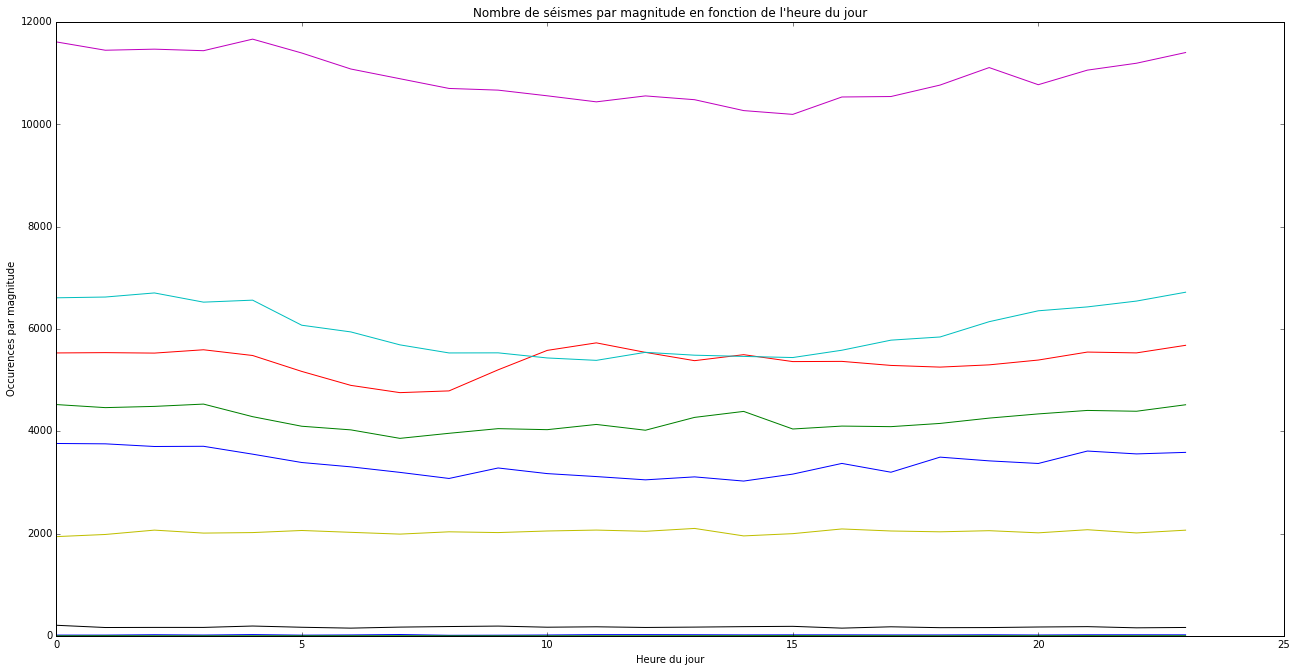

In [21]:
for m in range(0,10):
    quakes = selection(data, magnitudeMin = m, magnitudeMax = m+1, cause = "earthquake")
    #afficheLesSeismes(quakes)
    occurences, heures = np.histogram(quakes.heure,24,range=[0,24])
    plt.plot(heures[:-1],occurences)
plt.ylabel('Occurences par magnitude')
plt.xlabel('Heure du jour')
plt.title("Nombre de séismes par magnitude en fonction de l'heure du jour")
plt.show()
plt.close()

Tirez en les conclusions que vous voulez.

## Séismes induits

Les activités humaines ont un impact  -minime-sur l'activité sismique, sans aucun doute. Nous pouvons le voir en interrogeant la base de l'USGS qui indique clairement quant un évènement est lié à l'activité humaine.
L'USGS s'interroge pour savoir si l'augmentation récente et significative de tremblements de terre aux USA est liée à la fracturation hydrolique : http://earthquake.usgs.gov/research/induced/
Nous ne jugerons pas. Nous présentons simplement les données, sans commentaire.

Sélectionnons les séismes induits:

In [22]:
induits = selection(data, cause="nonSeismic")

Affichons leur nombre en fonction par année.

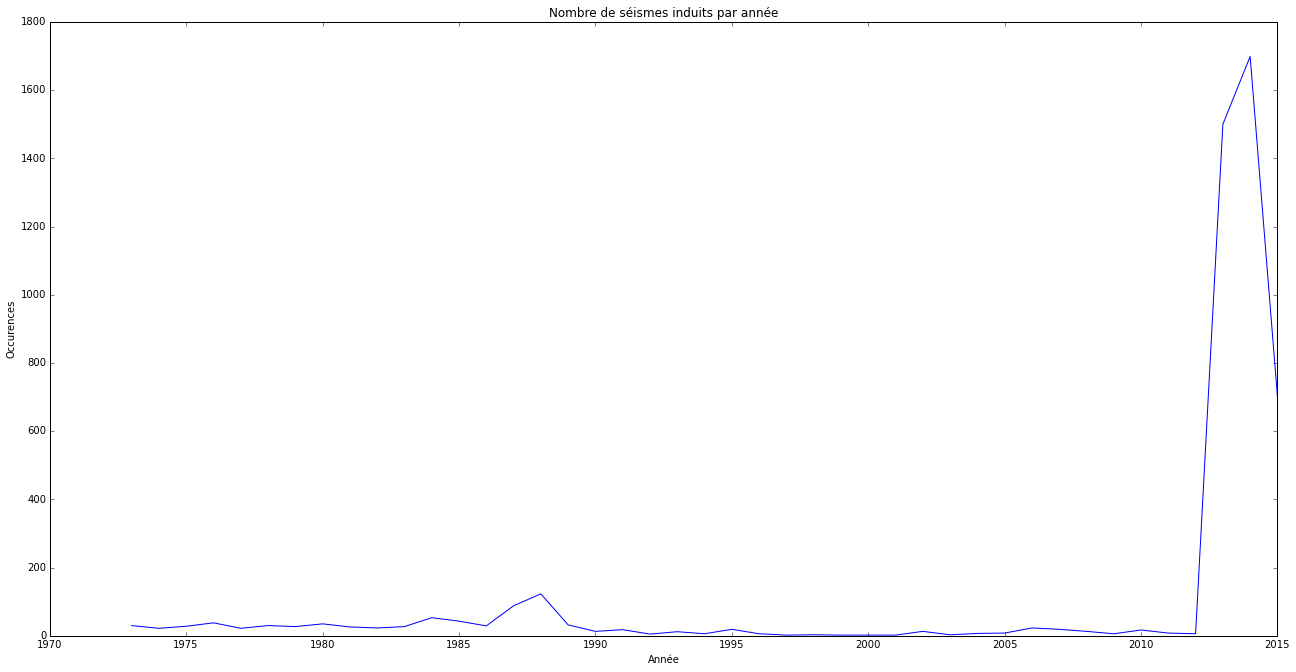

In [23]:
occurences, annees = np.histogram(induits.annee,43,range=[1973,2016])
plt.plot(annees[:-1],occurences)
plt.title("Nombre de séismes induits par année")
plt.ylabel('Occurences')
plt.xlabel('Année')
plt.show()
plt.close()

Aïe Aïe Aïe! Gros défaut de statistiques ou augmentation de l'activité humaine?

Voyons donc a quelle heure se produisent les séismes induits.

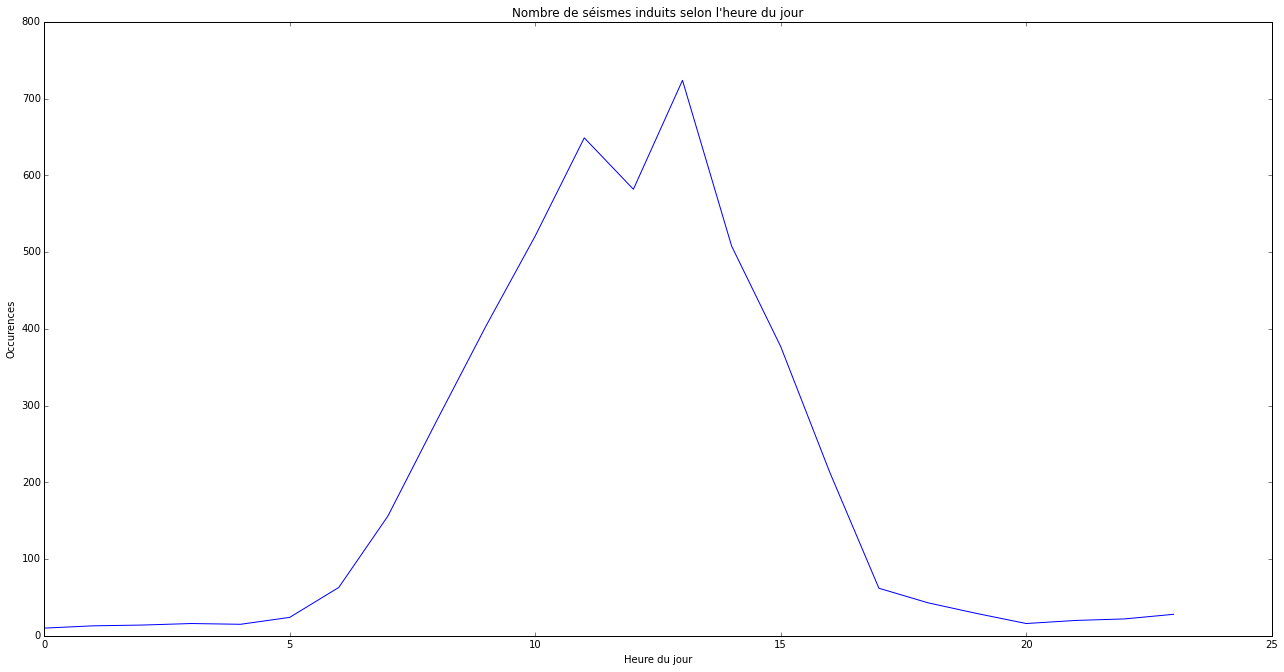

In [25]:
occurences, heures = np.histogram(induits.heure,24,range=[0,24])
plt.plot(heures[:-1],occurences)
plt.title("Nombre de séismes induits selon l'heure du jour")
plt.ylabel('Occurences')
plt.xlabel('Heure du jour')
plt.show()
plt.close()

Et oui! l'homme dort la nuit. Il est donc logique que ces séismes induits se produisent le jour.

Mais pour un séisme induit référencé, combien d'autres non identifiés? 